In [1015]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [1016]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [1017]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411115 entries, 0 to 2411114
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.8 MB


# reduce to 1 million events

In [1018]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [1019]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,34834,0.10,34.834
1,35008,0.10,35.008
2,34862,0.10,34.862
3,34983,0.10,34.983
4,34901,0.10,34.901
...,...,...,...
999995,19224,0.19,19.224
999996,18805,0.19,18.805
999997,18479,0.19,18.479
999998,18533,0.19,18.533


### conversion Interval -> kWh

In [1020]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,34834,0.10,34.834,103.347304
1,35008,0.10,35.008,102.833638
2,34862,0.10,34.862,103.264299
3,34983,0.10,34.983,102.907126
4,34901,0.10,34.901,103.148907
...,...,...,...,...
999995,19224,0.19,19.224,187.265918
999996,18805,0.19,18.805,191.438447
999997,18479,0.19,18.479,194.815737
999998,18533,0.19,18.533,194.248098


### Cumul Total interval

In [1021]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [1022]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

27129854776000

### Calcul de la date de base = now - cumul_interval

In [1023]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 9, 9, 10, 26, 28, 942859)

In [1024]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [1025]:
conso_data.iloc[0]


Interval     34834.000000
kWh              0.100000
sec             34.834000
Wh             103.347304
cumul(ms)    34834.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [1026]:
base

datetime.datetime(2024, 9, 9, 10, 26, 28, 942859)

## créer les dates

In [1027]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-09-09 10:27:03.776859
1        2024-09-09 10:27:38.784859
2        2024-09-09 10:28:13.646859
3        2024-09-09 10:28:48.629859
4        2024-09-09 10:29:23.530859
                    ...            
999995   2025-07-20 10:29:25.690859
999996   2025-07-20 10:29:44.495859
999997   2025-07-20 10:30:02.974859
999998   2025-07-20 10:30:21.507859
999999   2025-07-20 10:30:43.718859
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [1028]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,34834,0.10,34.834,103.347304,34834,2024-09-09 10:27:03.776859,09/09/24
1,35008,0.10,35.008,102.833638,69842,2024-09-09 10:27:38.784859,09/09/24
2,34862,0.10,34.862,103.264299,104704,2024-09-09 10:28:13.646859,09/09/24
3,34983,0.10,34.983,102.907126,139687,2024-09-09 10:28:48.629859,09/09/24
4,34901,0.10,34.901,103.148907,174588,2024-09-09 10:29:23.530859,09/09/24
...,...,...,...,...,...,...,...
999995,19224,0.19,19.224,187.265918,27129776748,2025-07-20 10:29:25.690859,20/07/25
999996,18805,0.19,18.805,191.438447,27129795553,2025-07-20 10:29:44.495859,20/07/25
999997,18479,0.19,18.479,194.815737,27129814032,2025-07-20 10:30:02.974859,20/07/25
999998,18533,0.19,18.533,194.248098,27129832565,2025-07-20 10:30:21.507859,20/07/25


### save conso_data with dates

In [1029]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [1030]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('20/07/25', 20, 7, 2025, '10:31:08')

In [1031]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [1032]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1190 entries, 998810 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1190 non-null   int64         
 1   kWh        1190 non-null   float64       
 2   sec        1190 non-null   float64       
 3   Wh         1190 non-null   float64       
 4   cumul(ms)  1190 non-null   int64         
 5   dates      1190 non-null   datetime64[ns]
 6   days       1190 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 74.4+ KB


In [1033]:
end = time.time()
print(end - start)

31.459067344665527


### grouped by days

In [1034]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [1035]:
data = list(df_grp['kWh'])
print(data)

[1.26, 1.799, 1.792, 1.796, 1.794, 2.409, 1.928, 1.788, 1.793, 1.788, 1.819, 1.82, 1.817, 1.815, 1.818, 1.817, 1.815, 1.819, 1.783, 1.788, 1.784, 1.785, 1.783, 1.798, 1.788, 1.791, 1.784, 1.793, 1.801, 1.798, 1.799, 1.801, 1.785, 1.787, 1.788, 1.788, 1.798, 1.791, 1.799, 1.804, 1.793, 1.802, 1.798, 2.636, 4.0, 3.68, 3.895, 3.092, 3.339, 4.149, 3.346, 3.524, 3.985, 3.322, 3.732, 3.568, 3.983, 3.203, 3.315, 3.385, 4.093, 3.293, 3.391, 3.813, 3.231, 3.544, 3.291, 3.915, 3.359, 3.414, 3.751, 4.411, 3.604, 3.853, 3.373, 4.226, 3.495, 3.45, 3.28, 3.861, 3.687, 4.116, 3.214, 3.726, 3.811, 3.153, 3.687, 3.644, 3.393, 3.883, 3.191, 4.058, 3.455, 3.693, 4.082, 3.404, 4.536, 3.268, 3.452, 3.121, 3.223, 3.424, 3.351, 3.426, 3.421, 4.594, 4.556, 3.228, 3.452, 3.636, 3.922, 3.554, 4.456, 4.177, 4.082, 3.789, 3.716, 3.568, 3.537, 4.389, 3.163, 3.38, 3.403, 3.449, 3.611, 3.375, 4.552, 3.262, 3.787, 3.249, 3.597, 3.546, 3.291, 3.987, 3.283, 4.664, 3.95, 3.312, 4.435, 3.508, 4.785, 3.812, 3.083, 3.232, 

In [1036]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [1037]:
end = time.time()
print(end - start)

32.56954312324524


### plot function by day
#### show('dd/mm/yy')

In [1038]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


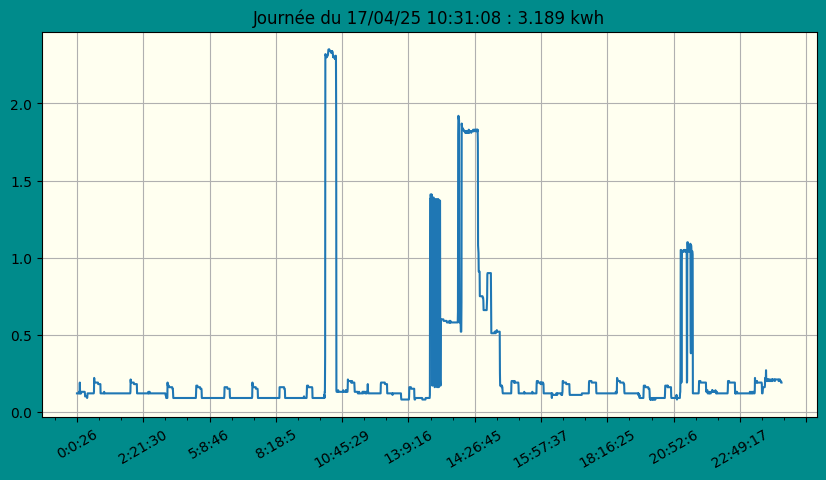

In [1039]:
show('17/04/25')

In [1040]:
end = time.time()
print(end - start)

33.963353872299194


### 1 kWh window in data of one day
#### df = conso_day

In [1041]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998810,16081,0.22,16.081,223.866675,27092011080,2025-07-20 00:00:00.022859,20/07/25
998811,16031,0.22,16.031,224.564905,27092027111,2025-07-20 00:00:16.053859,20/07/25
998812,16038,0.22,16.038,224.466891,27092043149,2025-07-20 00:00:32.091859,20/07/25
998813,16059,0.22,16.059,224.173361,27092059208,2025-07-20 00:00:48.150859,20/07/25
998814,15521,0.23,15.521,231.943818,27092074729,2025-07-20 00:01:03.671859,20/07/25
...,...,...,...,...,...,...,...
999995,19224,0.19,19.224,187.265918,27129776748,2025-07-20 10:29:25.690859,20/07/25
999996,18805,0.19,18.805,191.438447,27129795553,2025-07-20 10:29:44.495859,20/07/25
999997,18479,0.19,18.479,194.815737,27129814032,2025-07-20 10:30:02.974859,20/07/25
999998,18533,0.19,18.533,194.248098,27129832565,2025-07-20 10:30:21.507859,20/07/25


In [1042]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [1043]:
df = conso_day
len(df)

1190

In [1044]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-20 00:00:00.022859	2025-07-20 09:10:32.339859	9h 10m 32s 	1000
2025-07-20 09:10:32.339859	2025-07-20 10:30:43.718859	1h 20m 11s 	190


In [1045]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301685
dtype: float64

In [1046]:
end = time.time()
print(end - start)

34.59845733642578


## mean for data grouped by days

In [1047]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.174603
dtype: float64

In [1048]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.19)

# conso by date


In [1049]:
# select day
day = today

#day = '16/08/24'
day

'20/07/25'

In [1050]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998810,16081,0.22,16.081,223.866675,27092011080,2025-07-20 00:00:00.022859,20/07/25
998811,16031,0.22,16.031,224.564905,27092027111,2025-07-20 00:00:16.053859,20/07/25
998812,16038,0.22,16.038,224.466891,27092043149,2025-07-20 00:00:32.091859,20/07/25
998813,16059,0.22,16.059,224.173361,27092059208,2025-07-20 00:00:48.150859,20/07/25
998814,15521,0.23,15.521,231.943818,27092074729,2025-07-20 00:01:03.671859,20/07/25
...,...,...,...,...,...,...,...
999995,19224,0.19,19.224,187.265918,27129776748,2025-07-20 10:29:25.690859,20/07/25
999996,18805,0.19,18.805,191.438447,27129795553,2025-07-20 10:29:44.495859,20/07/25
999997,18479,0.19,18.479,194.815737,27129814032,2025-07-20 10:30:02.974859,20/07/25
999998,18533,0.19,18.533,194.248098,27129832565,2025-07-20 10:30:21.507859,20/07/25


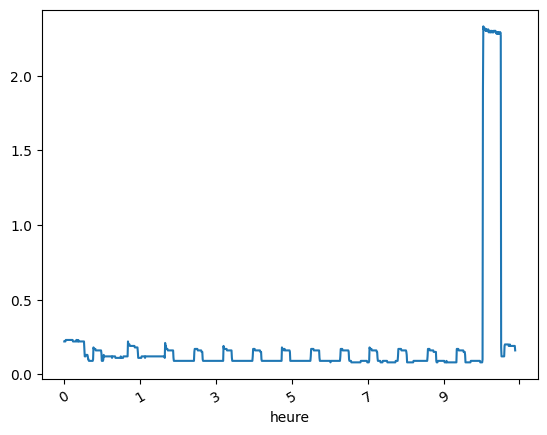

In [1051]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [1052]:
end = time.time()
print(end - start)

35.29026389122009


### grouped by 'heure'

In [1053]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1190 entries, 998810 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1190 non-null   int64         
 1   kWh        1190 non-null   float64       
 2   sec        1190 non-null   float64       
 3   Wh         1190 non-null   float64       
 4   cumul(ms)  1190 non-null   int64         
 5   dates      1190 non-null   datetime64[ns]
 6   days       1190 non-null   object        
 7   heure      1190 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 83.7+ KB


In [1054]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998810,16081,0.22,16.081,223.866675,27092011080,2025-07-20 00:00:00.022859,20/07/25
998811,16031,0.22,16.031,224.564905,27092027111,2025-07-20 00:00:16.053859,20/07/25
998812,16038,0.22,16.038,224.466891,27092043149,2025-07-20 00:00:32.091859,20/07/25
998813,16059,0.22,16.059,224.173361,27092059208,2025-07-20 00:00:48.150859,20/07/25
998814,15521,0.23,15.521,231.943818,27092074729,2025-07-20 00:01:03.671859,20/07/25
...,...,...,...,...,...,...,...
999995,19224,0.19,19.224,187.265918,27129776748,2025-07-20 10:29:25.690859,20/07/25
999996,18805,0.19,18.805,191.438447,27129795553,2025-07-20 10:29:44.495859,20/07/25
999997,18479,0.19,18.479,194.815737,27129814032,2025-07-20 10:30:02.974859,20/07/25
999998,18533,0.19,18.533,194.248098,27129832565,2025-07-20 10:30:21.507859,20/07/25


In [1055]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [1056]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     144
1     129
2     105
3      99
4     100
5     107
6      96
7      96
8     108
9      96
10    110
Name: kWh, dtype: int64

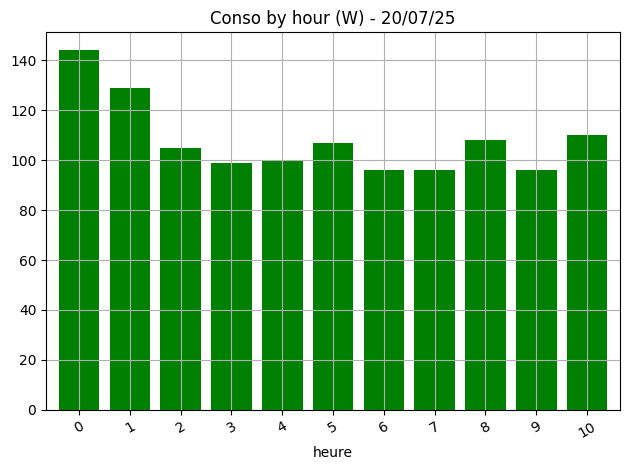

In [1057]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [1058]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 09/09/24 to 20/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     315 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [1059]:
# give the periods of 1 kwh in a day
period()

2025-07-20 00:00:00.022859	2025-07-20 09:10:32.339859	9h 10m 32s 	1000


In [1060]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [1061]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [1062]:
df_grp.mean()


kWh    3.174603
dtype: float64

In [1063]:
df_grp.head()


,kWh
days,
09/09/24,1.260
10/09/24,1.799
11/09/24,1.792
12/09/24,1.796
13/09/24,1.794


In [1064]:
df_grp.tail()


,kWh
days,
16/07/25,3.020
17/07/25,3.321
18/07/25,2.895
19/07/25,4.210
20/07/25,1.190


In [1065]:
end = time.time()
print(end - start)

36.948365688323975


# plot les 100 derniers jours


In [1066]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.00499
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

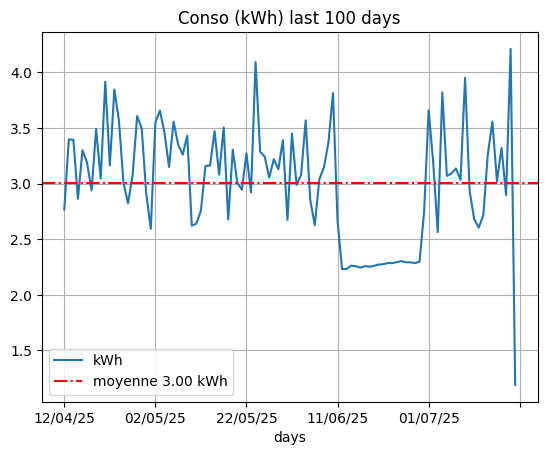

In [1067]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [1068]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.19
max,4.21


In [1069]:
end = time.time()
print(end - start)

37.66138219833374


In [1070]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('20/06/25', '15/07/25')

In [1071]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.877733
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

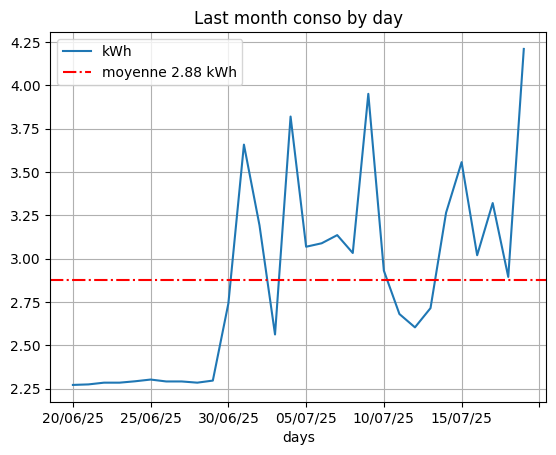

In [1072]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [1073]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 19/07/25 4.21
Min : 20/06/25 2.272


# Temps de conso par tranche de 1 kWh

In [1074]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


2
2025-07-20 00:00:00.022859	2025-07-20 09:10:32.339859	9h 10m 32s 	1000
2025-07-20 09:10:32.339859	2025-07-20 10:30:43.718859	1h 20m 11s 	190


In [1075]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('10:31:08', 1.19, 1190)

In [1076]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1190 entries, 998810 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1190 non-null   int64         
 1   kWh        1190 non-null   float64       
 2   sec        1190 non-null   float64       
 3   Wh         1190 non-null   float64       
 4   cumul(ms)  1190 non-null   int64         
 5   dates      1190 non-null   datetime64[ns]
 6   days       1190 non-null   object        
 7   heure      1190 non-null   object        
 8   hours      1190 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 93.0+ KB


In [1077]:
conso_hours['heure'], conso_hours['hours']

(998810     0
 998811     0
 998812     0
 998813     0
 998814     0
           ..
 999995    10
 999996    10
 999997    10
 999998    10
 999999    10
 Name: heure, Length: 1190, dtype: object,
 998810    00
 998811    00
 998812    00
 998813    00
 998814    00
           ..
 999995    10
 999996    10
 999997    10
 999998    10
 999999    10
 Name: hours, Length: 1190, dtype: object)

In [1078]:
end = time.time()
print(end - start)

38.931604862213135


# select number of days to display


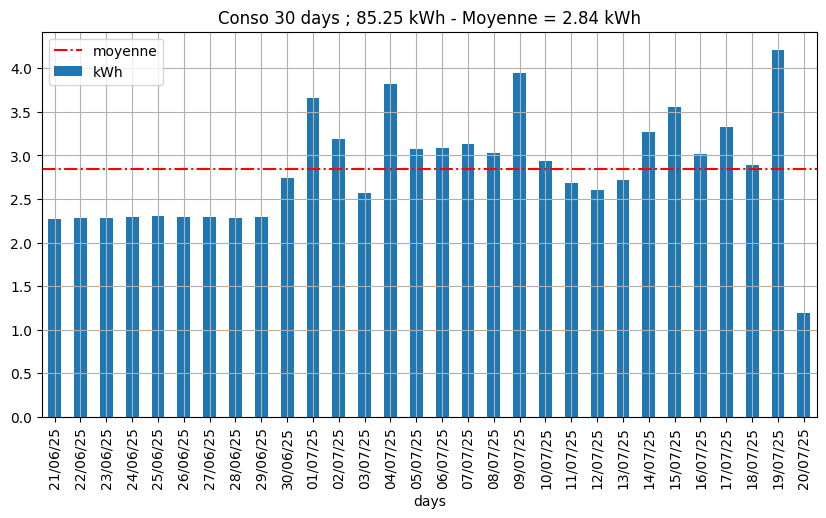

In [1079]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


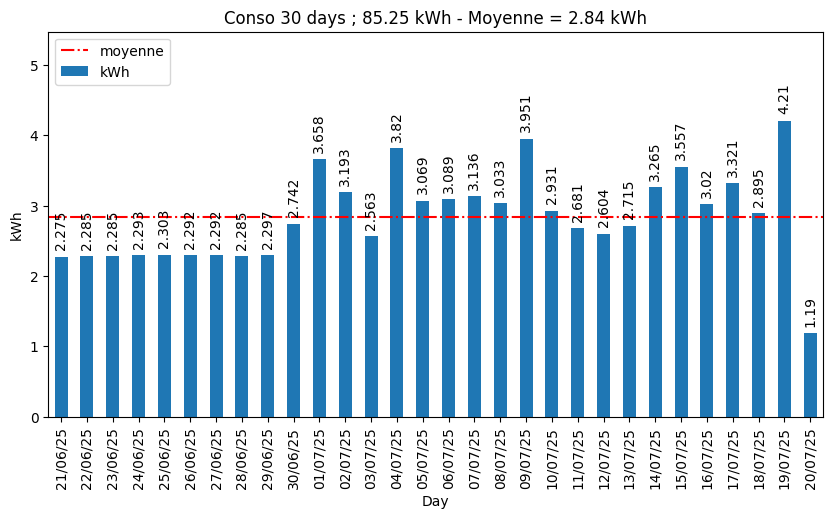

In [1080]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [1081]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
21/06/25    2.275
22/06/25    2.285
23/06/25    2.285
24/06/25    2.293
25/06/25    2.303
26/06/25    2.292
27/06/25    2.292
28/06/25    2.285
29/06/25    2.297
30/06/25    2.742
01/07/25    3.658
02/07/25    3.193
03/07/25    2.563
04/07/25    3.820
05/07/25    3.069
06/07/25    3.089
07/07/25    3.136
08/07/25    3.033
09/07/25    3.951
10/07/25    2.931
11/07/25    2.681
12/07/25    2.604
13/07/25    2.715
14/07/25    3.265
15/07/25    3.557
16/07/25    3.020
17/07/25    3.321
18/07/25    2.895
19/07/25    4.210
20/07/25    1.190
Name: kWh, dtype: float64

In [1082]:
x_labels=df_grp.tail(span).index
x_labels

Index(['21/06/25', '22/06/25', '23/06/25', '24/06/25', '25/06/25', '26/06/25',
       '27/06/25', '28/06/25', '29/06/25', '30/06/25', '01/07/25', '02/07/25',
       '03/07/25', '04/07/25', '05/07/25', '06/07/25', '07/07/25', '08/07/25',
       '09/07/25', '10/07/25', '11/07/25', '12/07/25', '13/07/25', '14/07/25',
       '15/07/25', '16/07/25', '17/07/25', '18/07/25', '19/07/25', '20/07/25'],
      dtype='object', name='days')

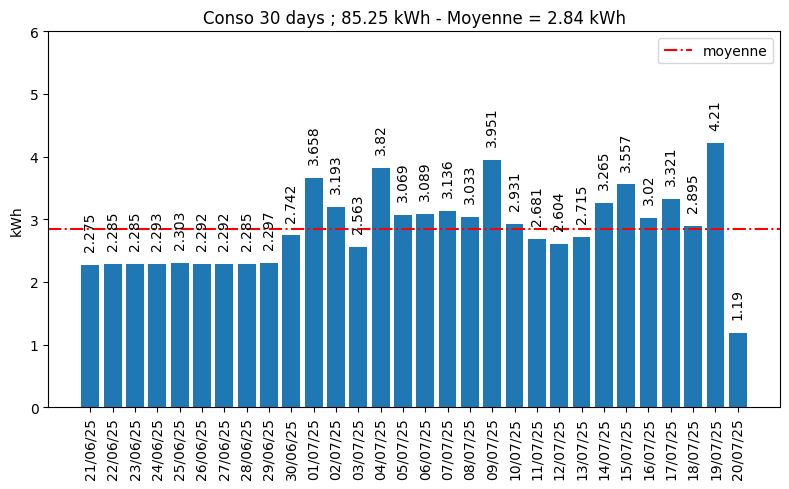

In [1083]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [1084]:
end = time.time()
print(end - start)

46.699700593948364


In [1085]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

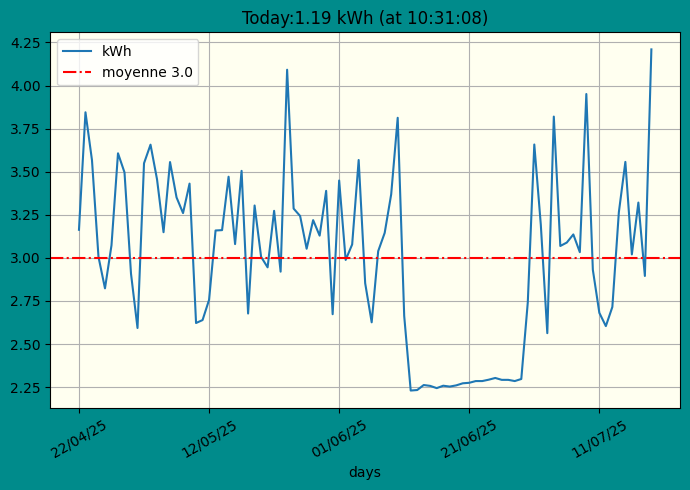

In [1086]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

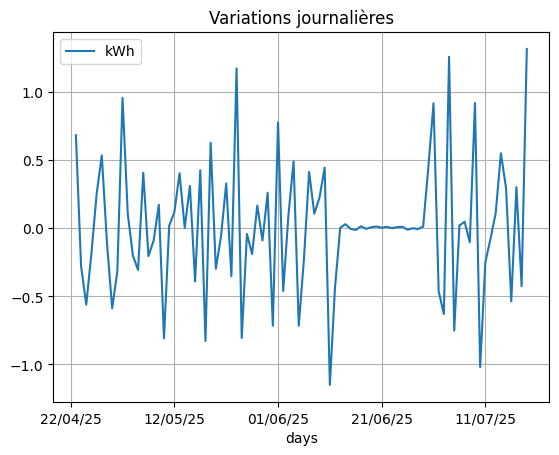

In [1087]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [1088]:
end = time.time()
print(end - start)

48.908703565597534


# Data from 21/08/23

In [1089]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,34834,0.10,34.834,103.347304,34834,2024-09-09 10:27:03.776859,09/09/24,10,2024-09,09
1,35008,0.10,35.008,102.833638,69842,2024-09-09 10:27:38.784859,09/09/24,10,2024-09,09
2,34862,0.10,34.862,103.264299,104704,2024-09-09 10:28:13.646859,09/09/24,10,2024-09,09
3,34983,0.10,34.983,102.907126,139687,2024-09-09 10:28:48.629859,09/09/24,10,2024-09,09
4,34901,0.10,34.901,103.148907,174588,2024-09-09 10:29:23.530859,09/09/24,10,2024-09,09
...,...,...,...,...,...,...,...,...,...,...
999995,19224,0.19,19.224,187.265918,27129776748,2025-07-20 10:29:25.690859,20/07/25,10,2025-07,20
999996,18805,0.19,18.805,191.438447,27129795553,2025-07-20 10:29:44.495859,20/07/25,10,2025-07,20
999997,18479,0.19,18.479,194.815737,27129814032,2025-07-20 10:30:02.974859,20/07/25,10,2025-07,20
999998,18533,0.19,18.533,194.248098,27129832565,2025-07-20 10:30:21.507859,20/07/25,10,2025-07,20


In [1090]:
end = time.time()
print(end - start)

110.68354940414429


In [1091]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

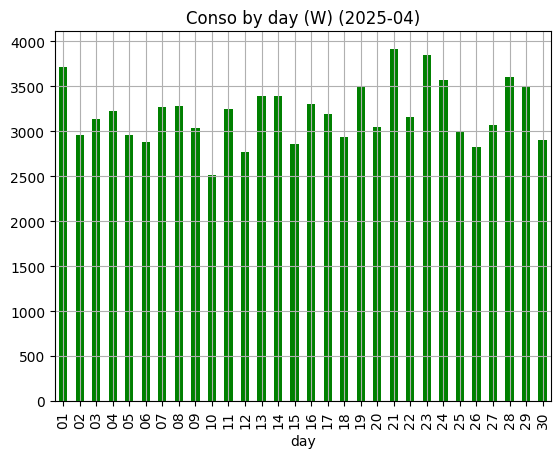

In [1092]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [1093]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3200.6666666666665)

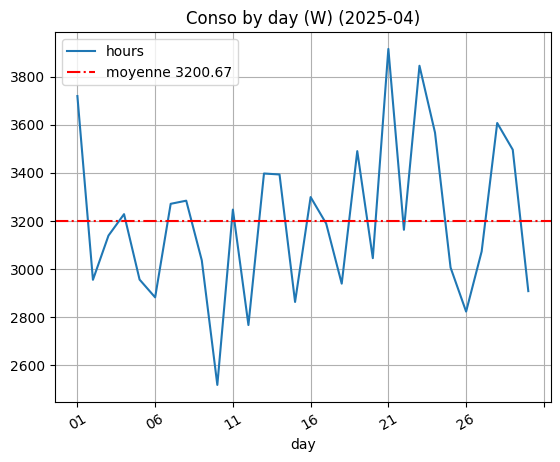

In [1094]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [1095]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

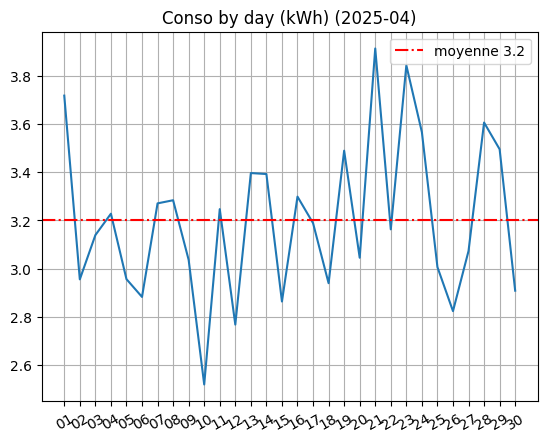

In [1096]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [1097]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [1098]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [1099]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-09,39827,39827,39827
2024-10,73315,73315,73315
2024-11,108173,108173,108173
2024-12,113977,113977,113977
2025-01,113887,113887,113887
2025-02,104271,104271,104271
2025-03,111816,111816,111816
2025-04,96020,96020,96020
2025-05,98604,98604,98604


In [1100]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [1101]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [1102]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
09/09/24,1260
10/09/24,1799
11/09/24,1792
12/09/24,1796
13/09/24,1794
...,...
16/07/25,3020
17/07/25,3321
18/07/25,2895


In [1103]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,34834,0.10,34.834,103.347304,34834,2024-09-09 10:27:03.776859,09/09/24,10,2024-09,09
1,35008,0.10,35.008,102.833638,69842,2024-09-09 10:27:38.784859,09/09/24,10,2024-09,09
2,34862,0.10,34.862,103.264299,104704,2024-09-09 10:28:13.646859,09/09/24,10,2024-09,09
3,34983,0.10,34.983,102.907126,139687,2024-09-09 10:28:48.629859,09/09/24,10,2024-09,09
4,34901,0.10,34.901,103.148907,174588,2024-09-09 10:29:23.530859,09/09/24,10,2024-09,09
...,...,...,...,...,...,...,...,...,...,...
999995,19224,0.19,19.224,187.265918,27129776748,2025-07-20 10:29:25.690859,20/07/25,10,2025-07,20
999996,18805,0.19,18.805,191.438447,27129795553,2025-07-20 10:29:44.495859,20/07/25,10,2025-07,20
999997,18479,0.19,18.479,194.815737,27129814032,2025-07-20 10:30:02.974859,20/07/25,10,2025-07,20
999998,18533,0.19,18.533,194.248098,27129832565,2025-07-20 10:30:21.507859,20/07/25,10,2025-07,20


In [1104]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
09/09/24 10    0       09/09/24    10  0.10
               1       09/09/24    10  0.10
               2       09/09/24    10  0.10
               3       09/09/24    10  0.10
               4       09/09/24    10  0.10
...                         ...   ...   ...
20/07/25 10    999995  20/07/25    10  0.19
               999996  20/07/25    10  0.19
               999997  20/07/25    10  0.19
               999998  20/07/25    10  0.19
               999999  20/07/25    10  0.16

[1000000 rows x 3 columns]

In [1105]:
groupallbyday.indices.keys()

dict_keys(['09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/11/24', '17/11/24', '18/11/24', '19/11/24', '20/11/24', '21/11/24', '22/11/24', '23/11/24', '24/11/24', '25/11/24', '26/11/24', '27/11/24', '28/11/24', '29/11/24', '30/1

In [1106]:
groupallbydayhours.indices.keys()

dict_keys([('09/09/24', '10'), ('09/09/24', '11'), ('09/09/24', '12'), ('09/09/24', '13'), ('09/09/24', '14'), ('09/09/24', '15'), ('09/09/24', '16'), ('09/09/24', '17'), ('09/09/24', '18'), ('09/09/24', '19'), ('09/09/24', '20'), ('09/09/24', '21'), ('09/09/24', '22'), ('09/09/24', '23'), ('10/09/24', '10'), ('10/09/24', '11'), ('10/09/24', '12'), ('10/09/24', '13'), ('10/09/24', '14'), ('10/09/24', '15'), ('10/09/24', '16'), ('10/09/24', '17'), ('10/09/24', '18'), ('10/09/24', '19'), ('10/09/24', '20'), ('10/09/24', '21'), ('10/09/24', '22'), ('10/09/24', '23'), ('10/09/24', '00'), ('10/09/24', '01'), ('10/09/24', '02'), ('10/09/24', '03'), ('10/09/24', '04'), ('10/09/24', '05'), ('10/09/24', '06'), ('10/09/24', '07'), ('10/09/24', '08'), ('10/09/24', '09'), ('11/09/24', '10'), ('11/09/24', '11'), ('11/09/24', '12'), ('11/09/24', '13'), ('11/09/24', '14'), ('11/09/24', '15'), ('11/09/24', '16'), ('11/09/24', '17'), ('11/09/24', '18'), ('11/09/24', '19'), ('11/09/24', '20'), ('11/09/2

In [1107]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
09/09/24,1260,1260
10/09/24,1799,1799
11/09/24,1792,1792
12/09/24,1796,1796
13/09/24,1794,1794
...,...,...
16/07/25,3020,3020
17/07/25,3321,3321
18/07/25,2895,2895


In [1108]:
grp_by_day['kWh'].cumsum()

days
09/09/24       1260
10/09/24       3059
11/09/24       4851
12/09/24       6647
13/09/24       8441
             ...   
16/07/25     988384
17/07/25     991705
18/07/25     994600
19/07/25     998810
20/07/25    1000000
Name: kWh, Length: 315, dtype: int64

In [1109]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
09/09/24 10      71
         11     195
         12     136
         13     124
         14      75
...             ...
20/07/25 06      96
         07      96
         08     108
         09      96
         10     110

[7537 rows x 1 columns]

In [1110]:
grp_by_dayhours['kWh'].cumsum()

days      hours
09/09/24  10            71
          11           266
          12           402
          13           526
          14           601
                    ...   
20/07/25  06        999590
          07        999686
          08        999794
          09        999890
          10       1000000
Name: kWh, Length: 7537, dtype: int64

In [1111]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
09/09/24 10      71      71    NaN
         11     195     266  124.0
         12     136     402  -59.0
         13     124     526  -12.0
         14      75     601  -49.0
...             ...     ...    ...
20/07/25 06      96     780  -11.0
         07      96     876    0.0
         08     108     984   12.0
         09      96    1080  -12.0
         10     110    1190   14.0

[7537 rows x 3 columns]

In [1112]:
today, grp_by_dayhours.loc[today]

('20/07/25',
        kWh  cumsum  diff
 hours                   
 00     144     144   NaN
 01     129     273 -15.0
 02     105     378 -24.0
 03      99     477  -6.0
 04     100     577   1.0
 05     107     684   7.0
 06      96     780 -11.0
 07      96     876   0.0
 08     108     984  12.0
 09      96    1080 -12.0
 10     110    1190  14.0)

Text(0.5, 1.0, 'Cumul journalier')

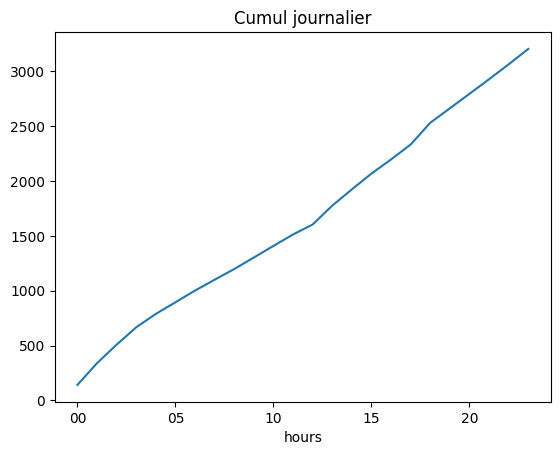

In [1113]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

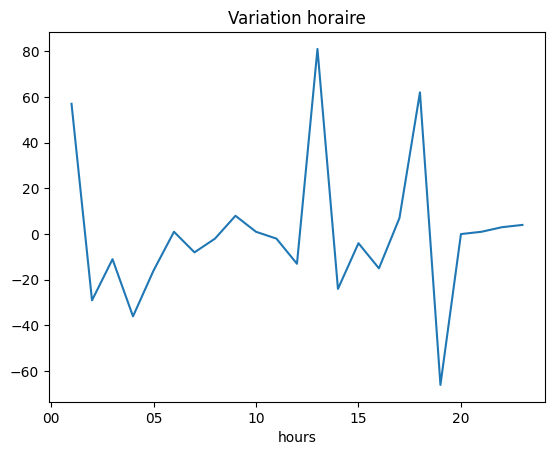

In [1114]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [1115]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

315

In [1116]:
df_grp.tail(n)['kWh'].describe()


count    315.000000
mean       3.174603
std        0.746152
min        1.190000
25%        2.838000
50%        3.312000
75%        3.657500
max        4.785000
Name: kWh, dtype: float64

In [1117]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [1118]:
n, np.nanmean(df_grp.tail(n))

(315, np.float64(3.1746031746031744))

Text(0.5, 1.0, '315 days')

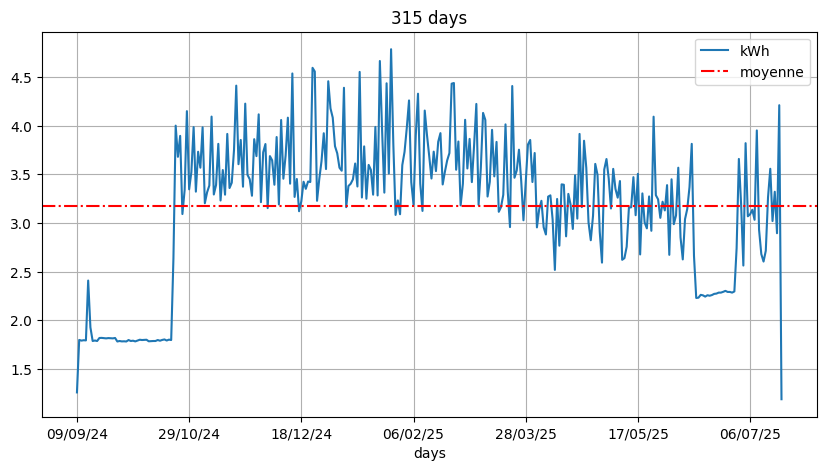

In [1119]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

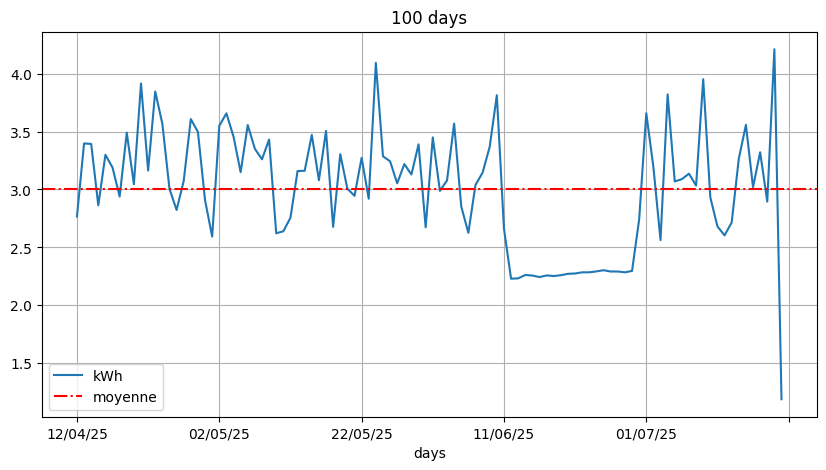

In [1120]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [1121]:
np.nanmean(df_grp.tail(span))

np.float64(3.0049900000000003)

In [1122]:
df_grp['kWh']

days
09/09/24    1.260
10/09/24    1.799
11/09/24    1.792
12/09/24    1.796
13/09/24    1.794
            ...  
16/07/25    3.020
17/07/25    3.321
18/07/25    2.895
19/07/25    4.210
20/07/25    1.190
Name: kWh, Length: 315, dtype: float64

In [1123]:
df_grp.describe()

,kWh
count,315.000000
mean,3.174603
std,0.746152
min,1.190000
25%,2.838000
50%,3.312000
75%,3.657500
max,4.785000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

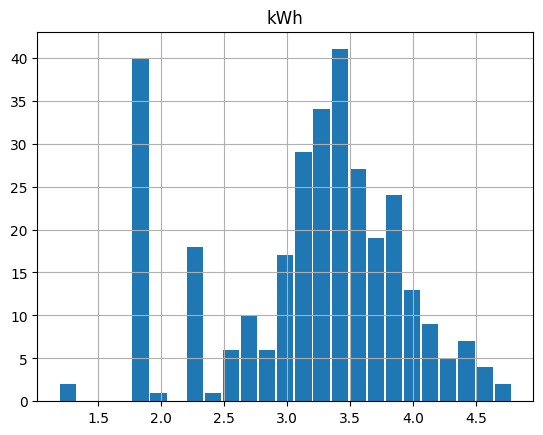

In [1124]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [1125]:
df_grp.tail(span)['kWh']

days
12/04/25    2.767
13/04/25    3.397
14/04/25    3.393
15/04/25    2.863
16/04/25    3.299
            ...  
16/07/25    3.020
17/07/25    3.321
18/07/25    2.895
19/07/25    4.210
20/07/25    1.190
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [1126]:
day

'20/07/25'

In [1127]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,144,144,NaN
01,129,273,-15.0
02,105,378,-24.0
03,99,477,-6.0
04,100,577,1.0
05,107,684,7.0
06,96,780,-11.0
07,96,876,0.0
08,108,984,12.0


In [1128]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


11

In [1129]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 12)

In [1130]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [1131]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [1132]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
Name: days, dtype: float64

In [1133]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [1134]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 00 to 10
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     11 non-null     int64  
 1   cumsum  11 non-null     int64  
 2   diff    10 non-null     float64
 3   days    11 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 440.0+ bytes


In [1135]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
Name: days, dtype: float64

In [1136]:
day

'20/07/25'

In [1137]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,144,144,NaN,1.0
01,129,273,-15.0,2.0
02,105,378,-24.0,3.0
03,99,477,-6.0,4.0
04,100,577,1.0,5.0
05,107,684,7.0,6.0
06,96,780,-11.0,7.0
07,96,876,0.0,8.0
08,108,984,12.0,9.0


In [1138]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_11012\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(1.1900000000000002)

In [1139]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
09/09/24 10      71      71    NaN   NaN
         11     195     266  124.0   NaN
         12     136     402  -59.0   NaN
         13     124     526  -12.0   NaN
         14      75     601  -49.0   NaN
...             ...     ...    ...   ...
20/07/25 06      96     780  -11.0   7.0
         07      96     876    0.0   8.0
         08     108     984   12.0   9.0
         09      96    1080  -12.0  10.0
         10     110    1190   14.0  11.0

[7537 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '20/07/25: kWh    1.19\ndtype: float64')

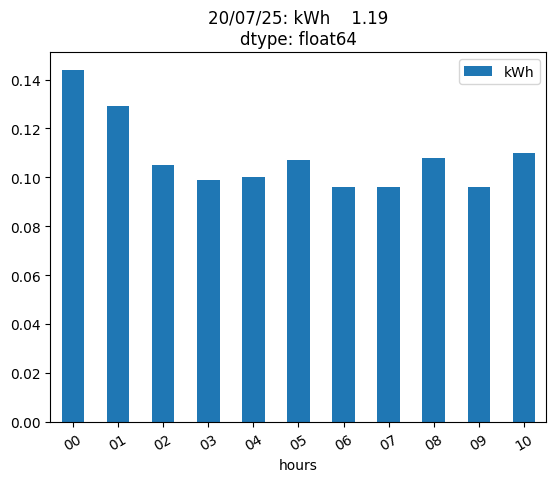

In [1140]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [1141]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10'], dtype='object', name='hours')

# Conso du jour


In [1142]:
grp_by_dayhours.count()

kWh       7537
cumsum    7537
diff      7222
days        11
dtype: int64

'27/01/25'

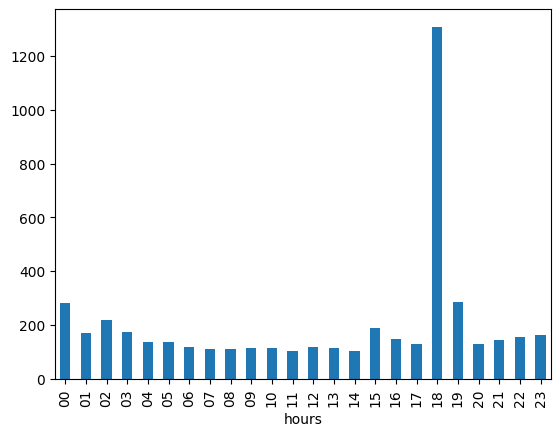

In [1143]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [1144]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 300.499 , Moyenne= 3.0049900000000003


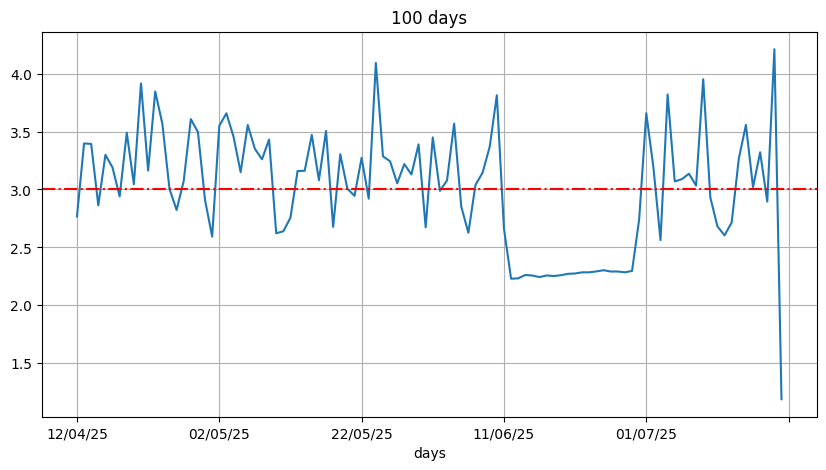

In [1145]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [1146]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 10:32:49, Minutes in day: 632


In [1147]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [1148]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

2:12.69


In [1149]:
end - start

132.6874177455902

In [1150]:
#df = conso_day
show_tranches()

2
2025-07-20 00:00:00.022859	2025-07-20 09:10:32.339859	9h 10m 32s 	1000
2025-07-20 09:10:32.339859	2025-07-20 10:30:43.718859	1h 20m 11s 	190


In [1151]:
df_grp.tail(7)['kWh']

days
14/07/25    3.265
15/07/25    3.557
16/07/25    3.020
17/07/25    3.321
18/07/25    2.895
19/07/25    4.210
20/07/25    1.190
Name: kWh, dtype: float64

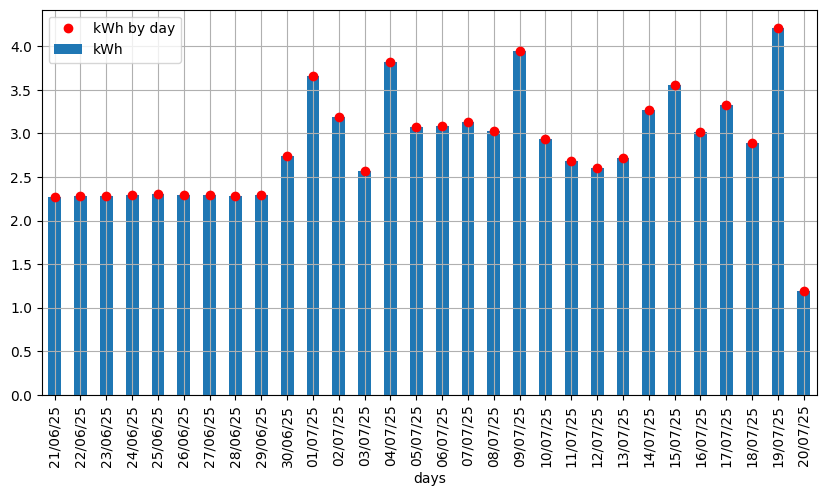

In [1152]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), kind='bar', layout='tight', grid=True)
plt.plot(df_grp.tail(30)['kWh'], 'ro', label='kWh by day')
plt.legend()

# Today

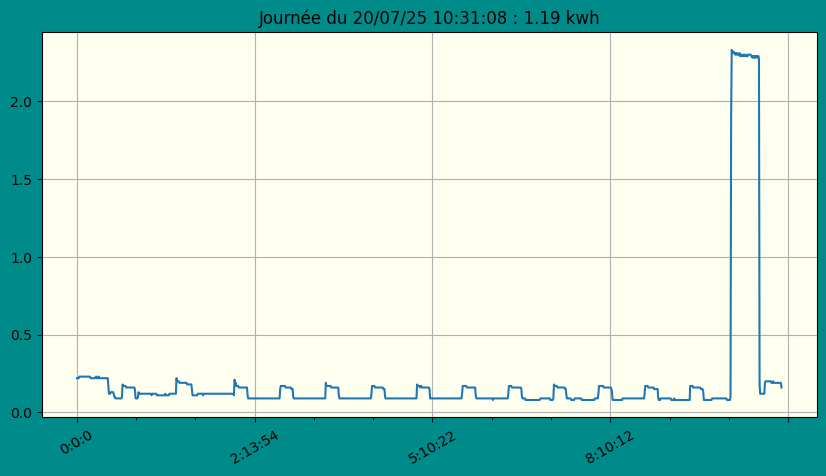

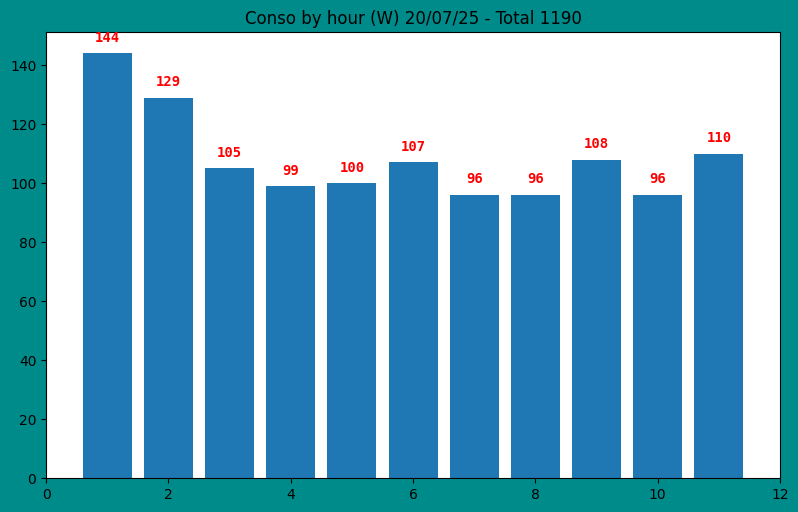

In [1153]:
show(today,bgcolor='ivory')
conso_by_hour(today)

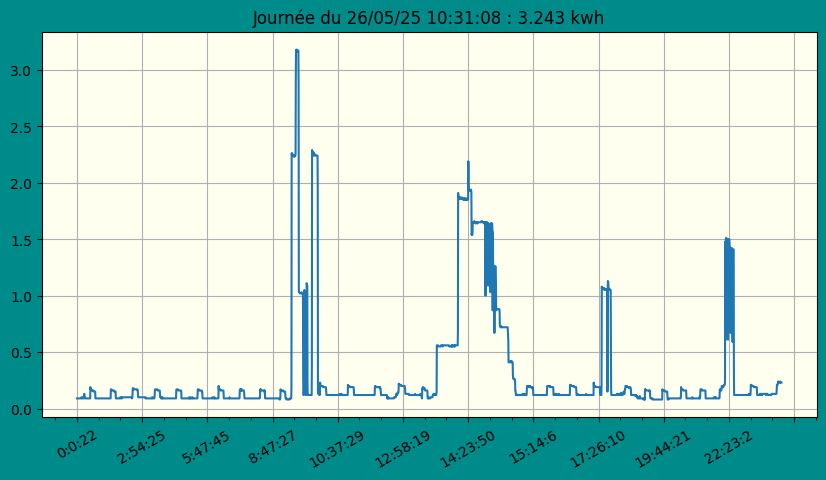

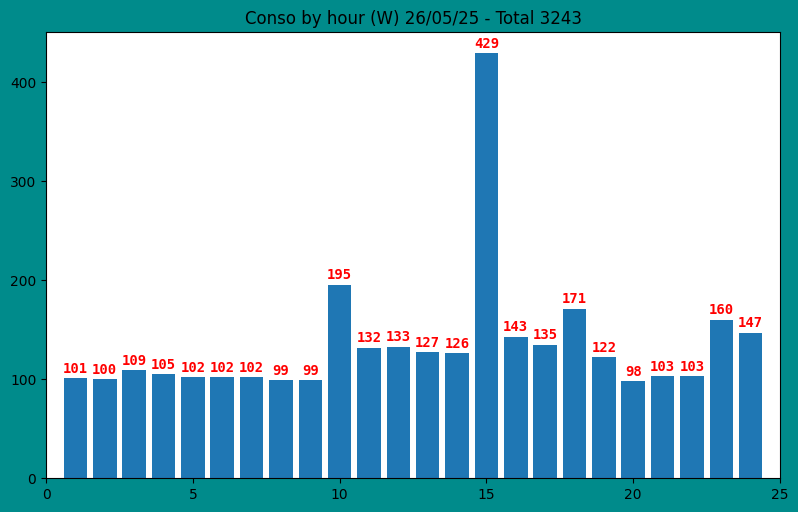

In [1154]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

27/01/25


(None, 4785)

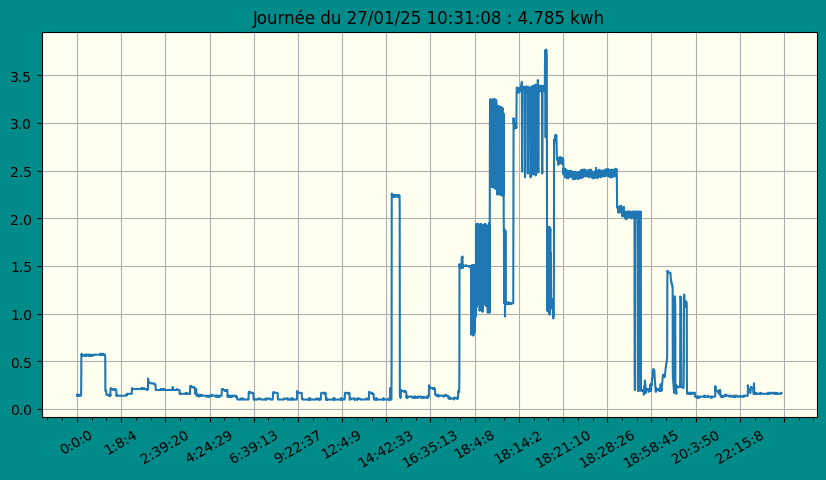

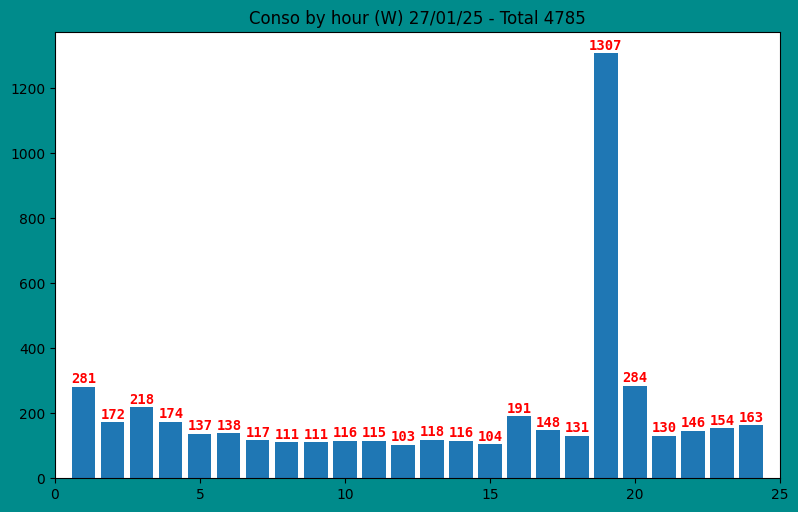

In [1155]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

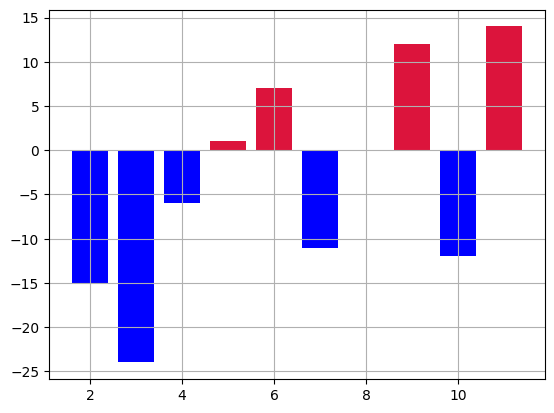

In [1156]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

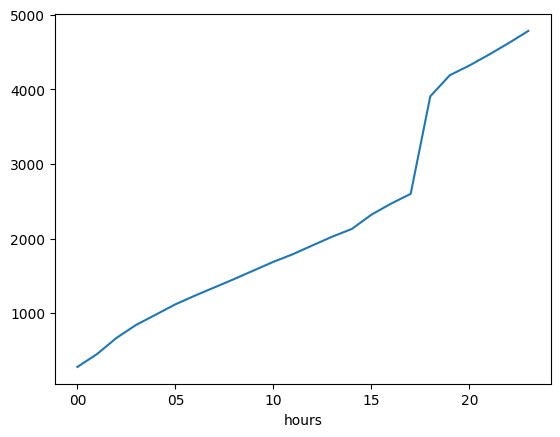

In [1157]:
data.cumsum().plot()


<Axes: xlabel='hours'>

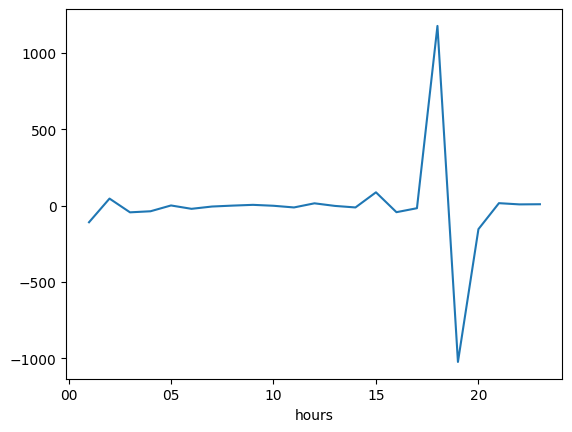

In [1158]:
# evolution par heure
data.diff().plot()

In [1159]:
data.diff().describe()

count      23.000000
mean       -5.130435
std       335.819663
min     -1023.000000
25%       -29.000000
50%        -2.000000
75%         8.500000
max      1176.000000
Name: kWh, dtype: float64

<Axes: >

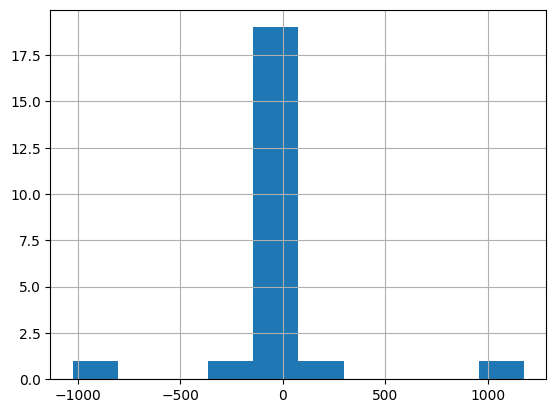

In [1160]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [1161]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'read_csv_conso.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_ch

# list store files csv


In [1162]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('27/01/25', None)

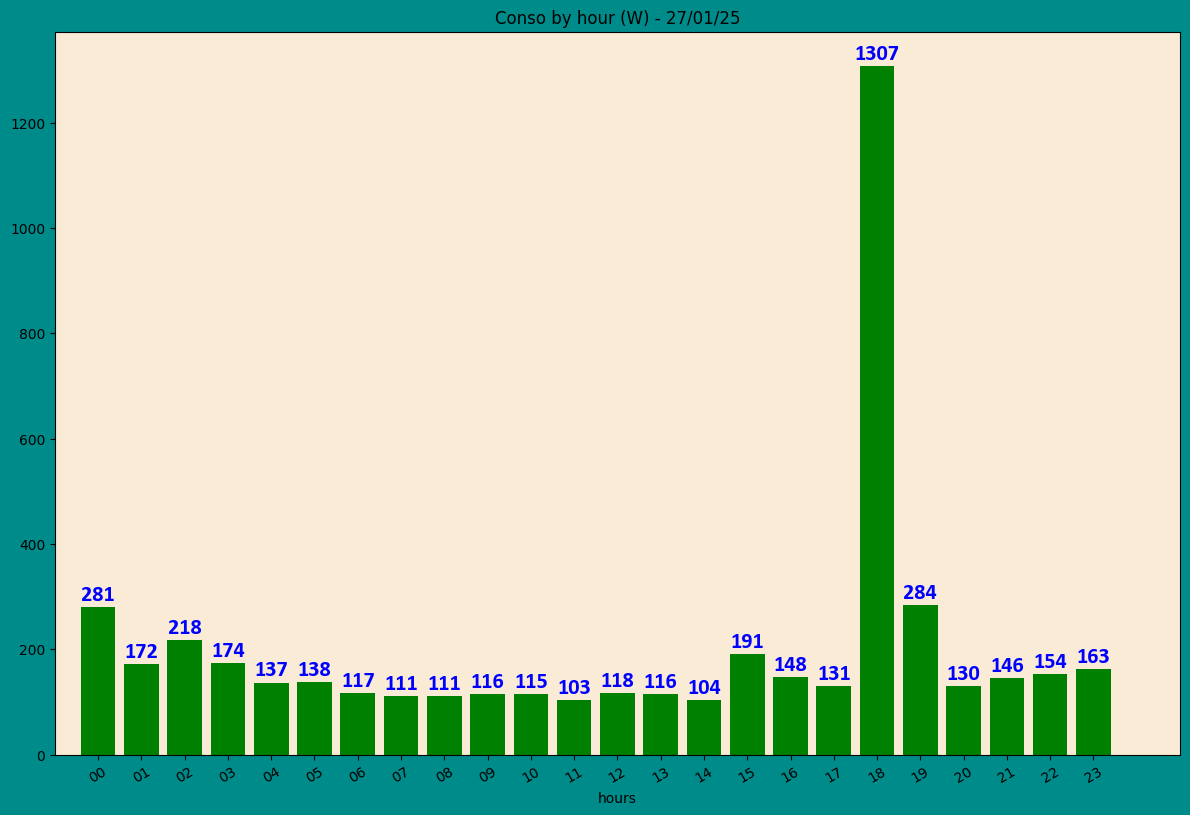

In [1163]:
day,conso_byhour(day)

In [1164]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


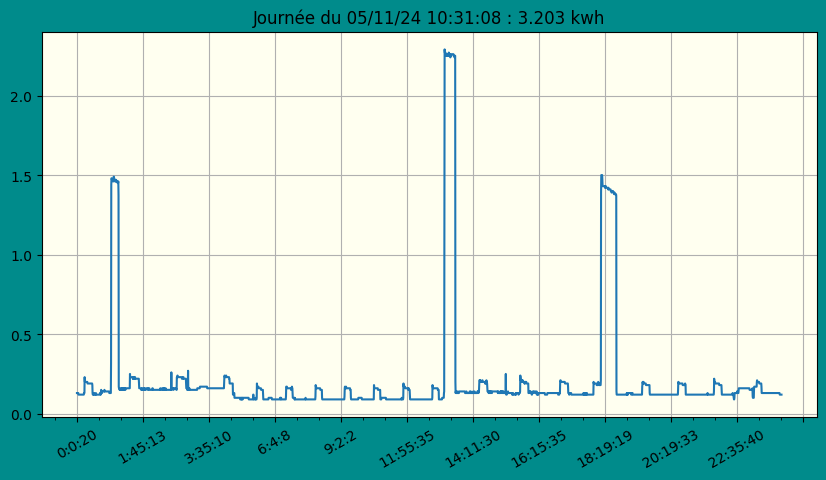

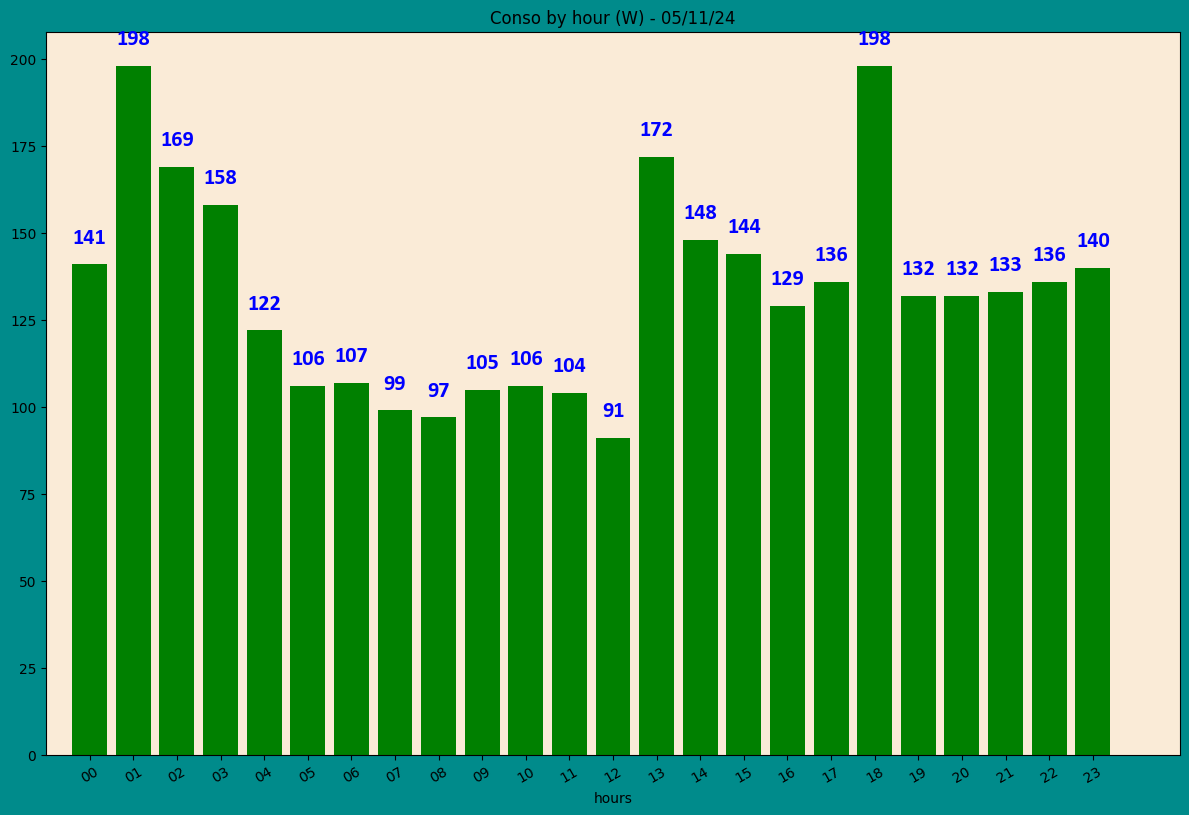

In [1165]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [1166]:
month

,day,hours,months,kWh
665266,01,00,2025-04,0.21
665267,01,00,2025-04,0.21
665268,01,00,2025-04,0.21
665269,01,00,2025-04,0.21
665270,01,00,2025-04,0.21
...,...,...,...,...
761281,30,23,2025-04,0.09
761282,30,23,2025-04,0.09
761283,30,23,2025-04,0.09
761284,30,23,2025-04,0.09


In [1167]:
month.describe()


,kWh
count,96020.000000
mean,0.310188
std,0.547315
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

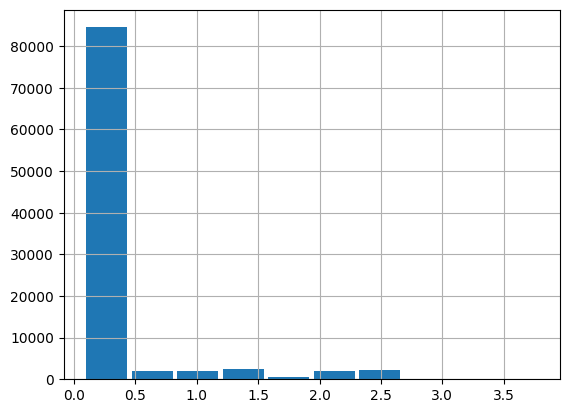

In [1168]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

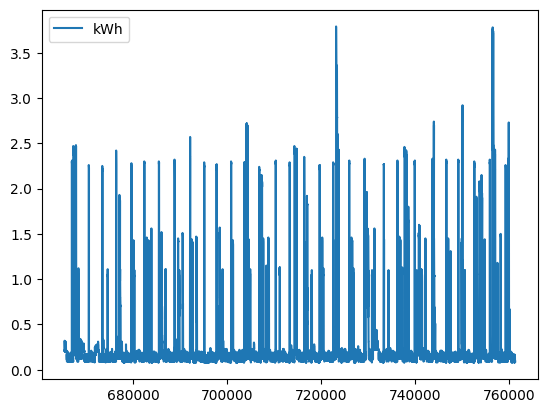

In [1169]:
month.plot()

In [1170]:
# index with max conso in this month
month.idxmax().kWh

np.int64(723151)

In [1171]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       758378
hours     668821
months    665266
kWh       723151
dtype: int64

In [1172]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [1173]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
09/09/24 10      71      71    NaN   NaN
         11     195     266  124.0   NaN
         12     136     402  -59.0   NaN
         13     124     526  -12.0   NaN
         14      75     601  -49.0   NaN
...             ...     ...    ...   ...
20/07/25 06      96     780  -11.0   7.0
         07      96     876    0.0   8.0
         08     108     984   12.0   9.0
         09      96    1080  -12.0  10.0
         10     110    1190   14.0  11.0

[7537 rows x 4 columns]

In [1174]:
month

,day,hours,months,kWh
665266,01,00,2025-04,0.21
665267,01,00,2025-04,0.21
665268,01,00,2025-04,0.21
665269,01,00,2025-04,0.21
665270,01,00,2025-04,0.21
...,...,...,...,...
761281,30,23,2025-04,0.09
761282,30,23,2025-04,0.09
761283,30,23,2025-04,0.09
761284,30,23,2025-04,0.09


In [1175]:
month.idxmax()


day       758378
hours     668821
months    665266
kWh       723151
dtype: int64

In [1176]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 723151, dtype: object

In [1177]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       179
          01       176
          02       171
          03       126
          04       114
          05       110
          06       107
          07       102
          08       111
          09       111
          10       104
          11       103
          12       166
          13       144
          14       143
          15       138
          16       202
          17       142
          18       152
          19       187
          20       154
          21       147
          22       142
          23       172
Name: kWh, dtype: int64

In [1178]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'16'

<Axes: xlabel='days,hours'>

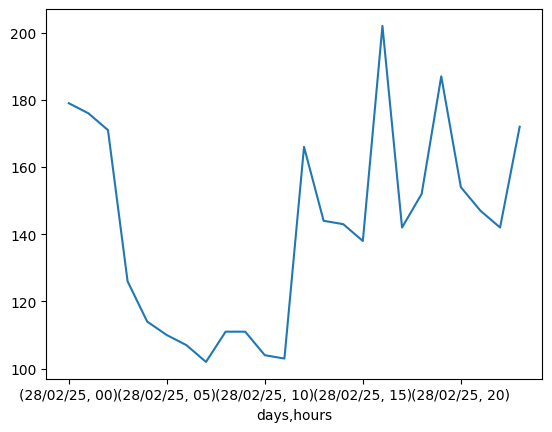

In [1179]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [1180]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [1181]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [1182]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [1183]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB